# Analysis Of The IRBD Cancelled Loans and The Prediction Model
__*Kyoosik Kim*__

## Introduction


------

## Dataset Preparation

In [1]:
# data frame
import numpy as np
import pandas as pd
import scipy as sc
pd.set_option('display.max_columns', 50)

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.plotly as py
import graphviz

# file system
from sodapy import Socrata
import os
import pickle

# data type
from datetime import datetime
import re

# word count
from collections import Counter
from fuzzywuzzy import fuzz, StringMatcher

# preparation for modeling
from sklearn.utils import shuffle
from sklearn import preprocessing as ppr

# modeling
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# model evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import *

# print
from pprint import pprint
from IPython.core.display import HTML
from IPython.display import IFrame

C:\Program Files\Python36\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning:

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.



In [2]:
"""
Set up a socrata client
Return the client and the meta data
"""
def client_setup(source, token, _id, _pw, file_code):
    client = Socrata(source, 
                 token, 
                 username=_id,
                 password=_pw)
    
    # id and password are not required
    # comment the above and comment out the code below
    # 
    # client = Socrata(source, None)
    
    meta_data = client.get_metadata(file_code)
    
    return client, meta_data


"""
Send a request via Socrata API with Query options
Pickle the result from the request and read it in DataFrame
Skip the process if the target file already exists
"""
def file_download(client, file_code, file_name, api_query):    
    # request only if the file does not exist
    if not os.path.isfile(file_name):
        results = client.get(file_code, 
                             where=api_query, 
                             limit=1000000) # supercede default = 1000
        # raw file to pickle file
        outfile = open(file_name, 'wb')
        pickle.dump(results, outfile)
        outfile.close()

    # from pickle file to data frame
    infile = open(file_name, 'rb')
    ibrd_dict = pickle.load(infile)
    ibrd_df = pd.DataFrame.from_records(ibrd_dict)
    infile.close()
    
    return ibrd_df

<br/>

### &bull; Meta Data

In [3]:
source = "finances.worldbank.org"
token = "your_token"
_id = "your_id"
_pw = "your_pw"
file_code = "x433-52wt"

client, meta_data = client_setup(source, token, _id, _pw, file_code)

In [4]:
print(meta_data.keys())

dict_keys(['id', 'name', 'attribution', 'attributionLink', 'averageRating', 'category', 'createdAt', 'description', 'displayType', 'downloadCount', 'hideFromCatalog', 'hideFromDataJson', 'indexUpdatedAt', 'licenseId', 'newBackend', 'numberOfComments', 'oid', 'provenance', 'publicationAppendEnabled', 'publicationDate', 'publicationGroup', 'publicationStage', 'rowsUpdatedAt', 'rowsUpdatedBy', 'tableId', 'totalTimesRated', 'viewCount', 'viewLastModified', 'viewType', 'columns', 'grants', 'license', 'metadata', 'owner', 'query', 'rights', 'tableAuthor', 'tags', 'flags'])


In [5]:
print(meta_data['description'])

The International Bank for Reconstruction and Development (IBRD) loans are public and publicly guaranteed debt extended by the World Bank Group. IBRD loans are made to, or guaranteed by, countries that are members of IBRD. IBRD may also make loans to IFC. IBRD lends at market rates. Data are in U.S. dollars calculated using historical rates. This dataset contains historical snapshots of the Statement of Loans including the latest available snapshots. The World Bank complies with all sanctions applicable to World Bank transactions.


In [6]:
ind_var = next(field for field in meta_data['columns'] 
               if field['fieldName'] == "loan_status")
pprint(ind_var['cachedContents']['top'])

[{'count': '372042', 'item': 'Repaid'},
 {'count': '152518', 'item': 'Fully Repaid'},
 {'count': '81096', 'item': 'Disbursed'},
 {'count': '48498', 'item': 'Disbursing'},
 {'count': '24597', 'item': 'Repaying'},
 {'count': '19267', 'item': 'Cancelled'},
 {'count': '12162', 'item': ' Repaid '},
 {'count': '7788', 'item': 'Fully Cancelled'},
 {'count': '6967', 'item': 'Fully Disbursed'},
 {'count': '5250', 'item': 'Fully Transferred'},
 {'count': '3638', 'item': 'Terminated'},
 {'count': '3358', 'item': 'Approved'},
 {'count': '3154', 'item': 'Disbursing&Repaying'},
 {'count': '2728', 'item': 'Effective'},
 {'count': '2539', 'item': 'Signed'},
 {'count': '2309', 'item': ' Disbursed '},
 {'count': '995', 'item': ' Disbursing '},
 {'count': '565', 'item': ' Cancelled '},
 {'count': '71', 'item': ' Terminated '},
 {'count': '62', 'item': ' Approved '}]


<br/>

### &bull; Dataset Load

In [7]:
api_query = "(loan_status='Repaid' or loan_status='Cancelled') and \
            closed_date_most_recent_ > '1980-01-01T00:00:00.000'"
ibrd_df = file_download(client, "x433-52wt", "ibrd_file", api_query)

In [8]:
ibrd_df.shape

(326674, 32)

In [9]:
ibrd_df.head()

,agreement_signing_date,board_approval_date,borrower,borrower_s_obligation,cancelled_amount,closed_date_most_recent_,country,country_code,disbursed_amount,due_3rd_party,due_to_ibrd,effective_date_most_recent_,end_of_period,exchange_adjustment,first_repayment_date,guarantor,guarantor_country_code,interest_rate,last_disbursement_date,last_repayment_date,loan_number,loan_status,loan_type,loans_held,original_principal_amount,project_id,project_name_,region,repaid_3rd_party,repaid_to_ibrd,sold_3rd_party,undisbursed_amount
0,1998-01-12T00:00:00.000,1998-01-12T00:00:00.000,INTERNATIONAL FINANCE CORPORATION,0.00,0.00,1998-06-30T00:00:00.000,World,1W,5000000.00,0.00,0.00,1998-01-12T00:00:00.000,2015-01-31T00:00:00.000,0.00,1999-12-15T00:00:00.000,World,1W,5.56,NaN,2006-06-15T00:00:00.000,IBRDM2405,Repaid,IFC LOAN,0.00,5000000.00,NaN,NaN,Other,0.00,5000000.00,0.00,0.00
1,1998-01-12T00:00:00.000,1998-01-12T00:00:00.000,INTERNATIONAL FINANCE CORPORATION,0.00,0.00,1998-06-30T00:00:00.000,World,1W,4000000.00,0.00,0.00,1998-01-12T00:00:00.000,2015-01-31T00:00:00.000,0.00,2000-07-15T00:00:00.000,World,1W,5.58,NaN,2009-01-15T00:00:00.000,IBRDM2406,Repaid,IFC LOAN,0.00,4000000.00,NaN,NaN,Other,0.00,4000000.00,0.00,0.00
2,1985-11-19T00:00:00.000,1985-11-19T00:00:00.000,INTERNATIONAL FINANCE CORPORATION,0.00,1200000.00,1991-09-15T00:00:00.000,World,1W,0.00,0.00,0.00,1985-11-19T00:00:00.000,2015-01-31T00:00:00.000,0.00,1989-11-15T00:00:00.000,World,1W,10.65,NaN,2000-05-15T00:00:00.000,IBRDM1105,Cancelled,IFC LOAN,0.00,1200000.00,NaN,NaN,Other,0.00,0.00,0.00,0.00
3,1985-12-05T00:00:00.000,1985-12-05T00:00:00.000,INTERNATIONAL FINANCE CORPORATION,0.00,10000000.00,1991-09-15T00:00:00.000,World,1W,0.00,0.00,0.00,1985-12-05T00:00:00.000,2015-01-31T00:00:00.000,0.00,1989-12-01T00:00:00.000,World,1W,10.65,NaN,2000-06-01T00:00:00.000,IBRDM1106,Cancelled,IFC LOAN,0.00,10000000.00,NaN,NaN,Other,0.00,0.00,0.00,0.00
4,2005-08-02T00:00:00.000,2005-05-17T00:00:00.000,Ministry of Finance,0.00,0.00,2011-03-31T00:00:00.000,Indonesia,ID,0.00,0.00,0.00,2005-10-28T00:00:00.000,2015-01-31T00:00:00.000,0.00,2010-11-15T00:00:00.000,Indonesia,ID,0.93,2009-07-06T00:00:00.000,2025-05-15T00:00:00.000,IBRD47790,Repaid,SNGL CRNCY,0.00,67300000.00,P084583,ID-UPP3,East Asia and Pacific,0.00,0.00,0.00,0.00


In [10]:
ibrd_df['loan_status'].value_counts()

Repaid       308536
Cancelled     18138
Name: loan_status, dtype: int64


------

<br/>

## Column Processing

In [11]:
ibrd_df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326674 entries, 0 to 326673
Columns: 32 entries, agreement_signing_date to undisbursed_amount
dtypes: object(32)
memory usage: 79.8+ MB


<br/>

### &bull; Null Values

In [12]:
def null_by_class(df, col):
    print("<'" + col + "' null values by class>")
    print("Number of null values with 'Repaid':",
      (df[df['loan_status']=='Repaid'][col].isnull()).sum())
    print("Number of null values with 'Cancelled':",
      (df[df['loan_status']=='Cancelled'][col].isnull()).sum())
    
def print_null_col(df):
    print("<Columns with null values>")
    pprint(list(df.columns[df.isnull().any()]))

In [13]:
print_null_col(ibrd_df)

<Columns with null values>
['agreement_signing_date',
 'borrower',
 'first_repayment_date',
 'guarantor',
 'guarantor_country_code',
 'interest_rate',
 'last_disbursement_date',
 'last_repayment_date',
 'project_id',
 'project_name_']


In [14]:
null_by_class(ibrd_df, 'project_name_')

<'project_name_' null values by class>
Number of null values with 'Repaid': 12892
Number of null values with 'Cancelled': 7387


In [15]:
ibrd_df.dropna(subset=['project_name_'], inplace=True)
print(ibrd_df.shape)

(306395, 32)


<br/>

__Agreement Signing Date__

In [16]:
print_null_col(ibrd_df)

<Columns with null values>
['agreement_signing_date',
 'borrower',
 'guarantor',
 'guarantor_country_code',
 'interest_rate',
 'last_disbursement_date']


In [17]:
null_by_class(ibrd_df, 'agreement_signing_date')

<'agreement_signing_date' null values by class>
Number of null values with 'Repaid': 315
Number of null values with 'Cancelled': 1406


In [18]:
ibrd_df.dropna(subset=['agreement_signing_date'], inplace=True)
print(ibrd_df.shape)

(304674, 32)


<br/>

__Guarantor__

In [19]:
print_null_col(ibrd_df)

<Columns with null values>
['borrower',
 'guarantor',
 'guarantor_country_code',
 'interest_rate',
 'last_disbursement_date']


In [20]:
diff_guarantor_df = (ibrd_df[ibrd_df['guarantor'] != ibrd_df['country']])
diff_guarantor_countries = diff_guarantor_df['country'].value_counts()

print("Number of the countries guaranted by another country:", len(diff_guarantor_df))
print("\n<Top 5 countries with another country as a guarantor>")
print(diff_guarantor_countries[:10])

Number of the countries guaranted by another country: 20944

<Top 5 countries with another country as a guarantor>
Portugal              1792
Indonesia             1419
Yugoslavia, former    1152
Oman                   960
Barbados               880
Mexico                 807
Brazil                 759
Greece                 706
Turkey                 604
Morocco                519
Name: country, dtype: int64


In [21]:
def guarantors_count(df, countries):
    for country in countries:
        vc = df[df['country'] == country]['guarantor'].value_counts()
        if vc.tolist(): # if not null
            print(country, ":" , vc, '\n')
            
guarantors_count(diff_guarantor_df, diff_guarantor_countries.keys())

Barbados : Caribbean    829
Name: guarantor, dtype: int64 

Western Africa : Cote d'Ivoire    61
Name: guarantor, dtype: int64 

Caribbean : Barbados    96
Name: guarantor, dtype: int64 



In [22]:
ibrd_df.drop(columns=['guarantor', 'guarantor_country_code'], inplace=True)
print(ibrd_df.shape)

(304674, 30)


<br/>

__Interest Rate__

In [23]:
null_by_class(ibrd_df, 'interest_rate')

<'interest_rate' null values by class>
Number of null values with 'Repaid': 2841
Number of null values with 'Cancelled': 293


In [24]:
# calculate mean interest rates by country
ibrd_df['interest_rate'] = ibrd_df['interest_rate'].astype(float)
country_interest = ibrd_df.groupby(['country'])['interest_rate'].mean()
country_interest = country_interest.to_dict()

# fill nan with country's mean interest rate
ibrd_df['interest_rate'] = ibrd_df.apply(lambda x : x['interest_rate'] if not np.isnan(x['interest_rate'])
                                         else country_interest.get(x['country']), axis=1)

<br/>

__Last Disbursement Date__

In [25]:
null_by_class(ibrd_df, 'last_disbursement_date')

<'last_disbursement_date' null values by class>
Number of null values with 'Repaid': 119654
Number of null values with 'Cancelled': 8579


In [26]:
print("Any Cancelled Loan with Disbursement:",
      (ibrd_df[ibrd_df['loan_status'] == 'Cancelled']['disbursed_amount'] != "0.00").sum())

Any Cancelled Loan with Disbursement: 0


In [27]:
ibrd_df.drop(columns=['last_disbursement_date'], inplace=True)
print(ibrd_df.shape)

(304674, 29)


<br/>

### &bull; Variable Drop and Type Conversion

In [28]:
ibrd_df.drop(columns=['borrower_s_obligation', 'cancelled_amount', 'disbursed_amount', 
                      'due_3rd_party', 'due_to_ibrd', 'exchange_adjustment', 'loans_held',
                      'repaid_3rd_party', 'repaid_to_ibrd', 'sold_3rd_party', 'undisbursed_amount'], inplace=True)
print(ibrd_df.shape)

(304674, 18)


In [29]:
"""
Convert variables to float or datetime
Or leave it as object type as given in raw dataset
"""
def type_convertor(df):
    numbers = 'amount|repaid|due|sold|held|adjustment|obligation'
    times = 'date|period'
    for col in df.columns:
        if re.search(numbers, str(col)):
            df[col] = df[col].astype(float)
        elif re.search(times, str(col)):
            df[col] = df[col].apply(lambda t : datetime.strptime(t[:10], '%Y-%m-%d'))
        
type_convertor(ibrd_df)
# loan type is more of categorical
ibrd_df['loan_type'] = ibrd_df['loan_type'].astype('category')
# cancelled = 1, the rest = 0
ibrd_df['loan_status'] = (ibrd_df['loan_status']=='Cancelled').astype(int)

In [30]:
ibrd_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304674 entries, 4 to 326673
Data columns (total 18 columns):
agreement_signing_date         304674 non-null datetime64[ns]
board_approval_date            304674 non-null datetime64[ns]
borrower                       304610 non-null object
closed_date_most_recent_       304674 non-null datetime64[ns]
country                        304674 non-null object
country_code                   304674 non-null object
effective_date_most_recent_    304674 non-null datetime64[ns]
end_of_period                  304674 non-null datetime64[ns]
first_repayment_date           304674 non-null datetime64[ns]
interest_rate                  304674 non-null float64
last_repayment_date            304674 non-null datetime64[ns]
loan_number                    304674 non-null object
loan_status                    304674 non-null int32
loan_type                      304674 non-null category
original_principal_amount      304674 non-null float64
project_id          

------

<br/>

### &bull; Date Variables

In [31]:
date_cols = list(ibrd_df.select_dtypes(include='datetime64').columns)
date_cols.append('loan_status')
ibrd_df.loc[ibrd_df['loan_status']==0, date_cols].head(10)

,agreement_signing_date,board_approval_date,closed_date_most_recent_,effective_date_most_recent_,end_of_period,first_repayment_date,last_repayment_date,loan_status
4,2005-08-02,2005-05-17,2011-03-31,2005-10-28,2015-01-31,2010-11-15,2025-05-15,0
5,2005-10-20,2005-06-07,2013-05-31,2006-01-18,2015-01-31,2010-11-15,2025-05-15,0
6,2005-08-04,2005-06-09,2012-12-31,2005-12-01,2015-01-31,2010-11-15,2025-05-15,0
7,2002-09-30,2002-06-18,2003-06-30,2002-12-03,2015-01-31,2012-05-15,2012-05-15,0
8,2002-07-29,2002-06-20,2006-09-30,2002-09-26,2015-01-31,2007-11-15,2019-05-15,0
10,2002-10-29,2002-06-27,2007-01-31,2003-03-17,2015-01-31,2008-04-15,2018-04-15,0
11,2002-09-30,2002-07-16,2006-12-31,2003-06-30,2015-01-31,2008-03-15,2017-09-15,0
13,2002-09-30,2002-08-06,2003-12-31,2002-12-17,2015-01-31,2013-08-01,2013-08-01,0
14,2002-08-08,2002-08-08,2004-12-31,2002-08-09,2015-01-31,2005-10-15,2007-04-15,0
15,2002-10-29,2002-08-08,2007-02-28,2003-02-04,2015-01-31,2008-10-15,2018-04-15,0


In [32]:
ibrd_df.loc[ibrd_df['loan_status']==1, date_cols].head(10)

,agreement_signing_date,board_approval_date,closed_date_most_recent_,effective_date_most_recent_,end_of_period,first_repayment_date,last_repayment_date,loan_status
74,2003-03-21,2003-03-06,2005-02-16,2004-12-21,2015-01-31,2008-09-01,2020-03-01,1
159,2002-09-23,2001-03-22,2006-06-30,2003-01-22,2015-01-31,2006-11-15,2021-05-15,1
178,2003-09-23,2003-07-31,2008-06-30,2004-03-22,2015-01-31,2008-12-15,2018-06-15,1
203,1984-06-05,1984-05-31,1994-08-06,1984-05-31,2015-01-31,1993-06-01,1994-06-01,1
219,1985-03-22,1984-06-14,1988-07-01,1985-03-22,2015-01-31,1994-01-15,1994-07-15,1
220,1985-03-22,1984-06-14,1988-07-01,1985-03-22,2015-01-31,1994-07-15,1995-01-15,1
225,1985-10-25,1985-10-22,1987-12-31,1985-10-25,2015-01-31,1996-05-01,1997-11-01,1
267,1998-12-16,1998-04-23,2006-04-01,1999-06-28,2015-01-31,2003-11-15,2015-05-15,1
271,2006-06-05,2006-02-16,2010-06-30,2006-09-08,2015-01-31,2011-06-15,2022-12-15,1
289,2002-09-30,2002-09-10,2005-04-28,2003-01-28,2015-01-31,2009-08-15,2017-02-15,1


In [33]:
# days taken from board approval to signing
ibrd_df['days_for_signing'] = [(d[0]-d[1]).days for d in \
        zip(ibrd_df['agreement_signing_date'], ibrd_df['board_approval_date'])]

# agreed days for repayment
ibrd_df['days_for_repayment'] = [(d[0]-d[1]).days for d in \
        zip(ibrd_df['last_repayment_date'], ibrd_df['first_repayment_date'])]


------

<br/>

## Data Exploration

In [34]:
average_repayment_duration = (ibrd_df['closed_date_most_recent_'] 
                              - ibrd_df['agreement_signing_date']).mean().days/365
print("Average loan duration from signing to closing:", 
      round(average_repayment_duration, 2))

Average loan duration from signing to closing: 6.06


<br/>

### &bull; Numerical Data

In [35]:
display(HTML(ibrd_df.describe().drop('count').T.to_html()))

,mean,std,min,25%,50%,75%,max
interest_rate,5.982840e+00,2.795458e+00,0.0,4.85,6.18,7.90,1.200000e+01
loan_status,3.067213e-02,1.724281e-01,0.0,0.00,0.00,0.00,1.000000e+00
original_principal_amount,6.200329e+07,1.111631e+08,0.0,10100000.00,29000000.00,73943876.26,3.000000e+09
days_for_signing,1.161685e+02,2.791598e+02,0.0,16.00,38.00,98.00,3.083000e+03
days_for_repayment,4.304070e+03,1.443212e+03,-29404.0,3653.00,4202.00,5295.00,8.950000e+03


In [36]:
ibrd_df.loc[ibrd_df['days_for_repayment'] < 0, 
            ['first_repayment_date', 'last_repayment_date']].head(10)

,first_repayment_date,last_repayment_date
108,2015-02-15,1939-02-15
217,2015-11-15,1935-05-15
7280,2015-11-15,1935-05-15
7304,2015-02-15,1939-02-15
10885,2015-02-15,1939-02-15
10887,2015-11-15,1935-05-15
16907,2015-02-15,1939-02-15
16991,2015-11-15,1935-05-15
23720,2015-02-15,1939-02-15
23721,2015-11-15,1935-05-15


In [37]:
ibrd_df = ibrd_df[ibrd_df['days_for_repayment'] > 0]
print(ibrd_df.shape)

(302190, 20)


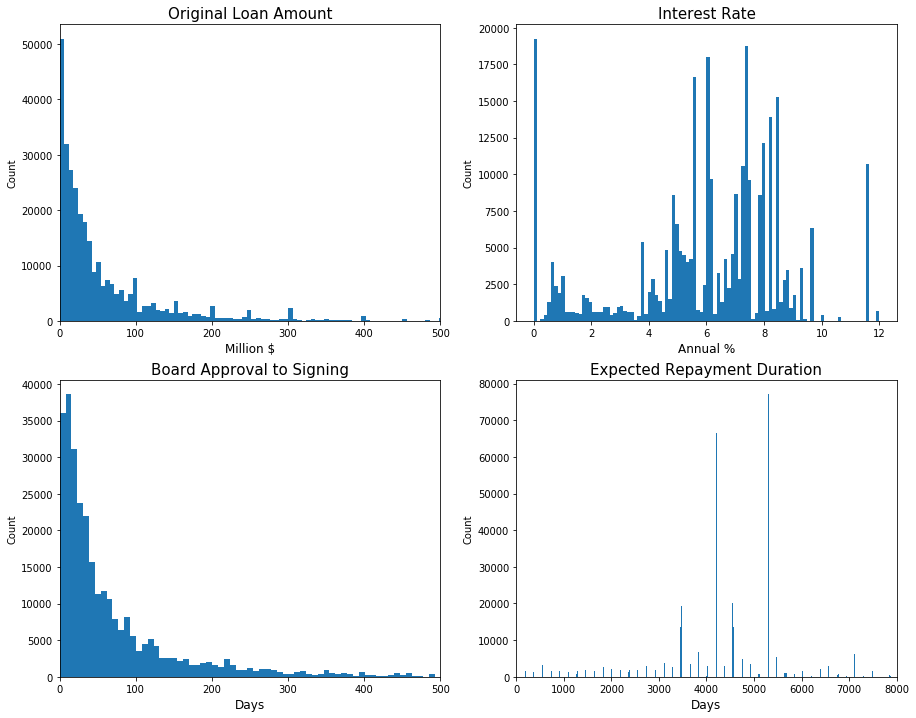

In [38]:
fig, axes = plt.subplots(2, 2, figsize=(15,12))

# dollar amount
axes[0,0].hist(ibrd_df['original_principal_amount'], bins=500)
axes[0,0].set_xlim(0, 0.5e9)
axes[0,0].set_xticks(np.arange(0, 0.6e9, 1e8))
axes[0,0].set_xticklabels(['0', '100', '200', '300', '400', '500'])
axes[0,0].set_title("Original Loan Amount", fontsize=15)
axes[0,0].set_xlabel("Million $", fontsize=12)
axes[0,0].set_ylabel("Count")

# interest rate
axes[0,1].hist(ibrd_df['interest_rate'], bins=100)
axes[0,1].set_title("Interest Rate", fontsize=15)
axes[0,1].set_xlabel("Annual %", fontsize=12)
axes[0,1].set_ylabel("Count")

# days from approval to signing
axes[1,0].hist(ibrd_df['days_for_signing'], bins=400)
axes[1,0].set_xlim(0, 500)
axes[1,0].set_title("Board Approval to Signing", fontsize=15)
axes[1,0].set_xlabel("Days", fontsize=12)
axes[1,0].set_ylabel("Count")

# days for repayment
axes[1,1].hist(ibrd_df['days_for_repayment'], bins=400)
axes[1,1].set_xlim(0, 0.8e4)
axes[1,1].set_title("Expected Repayment Duration", fontsize=15)
axes[1,1].set_xlabel("Days", fontsize=12)
axes[1,1].set_ylabel("Count")

plt.show()

In [39]:
corr = ibrd_df.loc[:, ibrd_df.columns != 'loan_status'].corr()
corr

,interest_rate,original_principal_amount,days_for_signing,days_for_repayment
interest_rate,1.000000,-0.167315,0.074184,0.116876
original_principal_amount,-0.167315,1.000000,-0.063718,-0.056885
days_for_signing,0.074184,-0.063718,1.000000,0.043571
days_for_repayment,0.116876,-0.056885,0.043571,1.000000


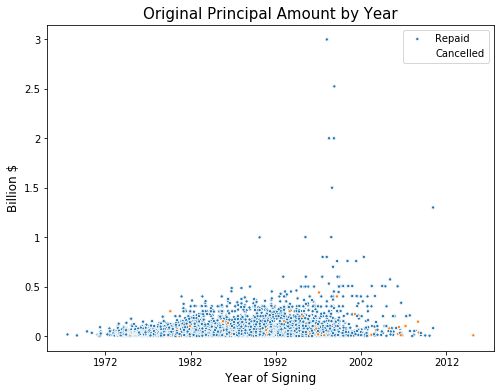

In [40]:
plt.figure(figsize=(8,6))

ax = sns.scatterplot(x='agreement_signing_date',
                     y='original_principal_amount', 
                     hue='loan_status', data=ibrd_df, s=10, legend='full')
ax.set_title("Original Principal Amount by Year", fontsize=15)
ax.set_xlabel("Year of Signing", fontsize=12)
ax.set_ylabel("Billion $", fontsize=12)
ax.set_yticks(np.arange(0, 3.1e9, 0.5e9))
ax.set_yticklabels(['0', '0.5', '1', '1.5', '2', '2.5', '3'])
ax.legend(['Repaid', 'Cancelled'])

plt.show()

In [41]:
cancelled_max = max(ibrd_df[ibrd_df['loan_status']==1]['original_principal_amount'])
ibrd_df = ibrd_df[ibrd_df['original_principal_amount'] < cancelled_max]

print("Maximum dollar amount among cancelled loans:", cancelled_max/1e9, "billion $")
print("Data Frame Shape:", ibrd_df.shape)

Maximum dollar amount among cancelled loans: 0.44 billion $
Data Frame Shape: (299458, 20)


<br/>

### &bull; Categorical Data

In [42]:
display(HTML(ibrd_df.describe(include=['object', 'category'])\
             .drop('count').T.to_html()))

,unique,top,freq
borrower,713,Ministry of Finance,39100
country,109,Indonesia,29880
country_code,109,ID,29880
loan_number,5150,IBRD3341A,65
loan_type,8,POOL LOAN,140768
project_id,3362,P005748,704
project_name_,2849,EDUCATION II,1796
region,12,Latin America and Caribbean,48158


------

<br/>

## Independent Variable: *Loan Status*

In [43]:
borrowers_sum = ibrd_df.groupby(['country'])['original_principal_amount'].sum()
borrowers_sum_df = pd.DataFrame({'Country': borrowers_sum.keys(), 
                                 'Total Amount': borrowers_sum.values/1_000_000_000})

borrowers_sum_df['Total Amount'] = round(borrowers_sum_df['Total Amount'], 2)
borrowers_sum_df.sort_values(by='Total Amount', ascending=False, inplace=True)

display(HTML(borrowers_sum_df.head(10).to_html()))

,Country,Total Amount
62,Mexico,1610.01
9,Brazil,1609.47
41,Indonesia,1576.98
40,India,1257.13
100,Turkey,856.75
15,China,746.51
1,Argentina,679.57
74,Philippines,539.00
16,Colombia,524.49
50,"Korea, Republic of",506.37


Remember there are several other loan status

In [44]:
cancel_rate = ibrd_df.groupby(['country'])['loan_status'].mean()

In [45]:
print("Countries with no cancellation")
print(cancel_rate[(cancel_rate==0)].keys())

Countries with no cancellation
Index(['Bahamas, The', 'Barbados', 'Belarus', 'Belize', 'Bolivia',
       'Bosnia and Herzegovina', 'Botswana', 'Chad',
       'Congo, Democratic Republic of', 'Cote d'Ivoire', 'Croatia',
       'Czech Republic', 'Eastern Africa', 'Estonia', 'Fiji', 'Gabon', 'Ghana',
       'Grenada', 'Guatemala', 'Guyana', 'Honduras',
       'Iran, Islamic Republic of', 'Iraq', 'Ireland', 'Israel', 'Kazakhstan',
       'Lesotho', 'Liberia', 'Lithuania',
       'Macedonia, former Yugoslav Republic', 'Madagascar', 'Malawi',
       'Mauritania', 'Mauritius', 'Moldova', 'Montenegro', 'Nicaragua',
       'Nigeria', 'Oman', 'Papua New Guinea', 'Senegal', 'Seychelles',
       'Sierra Leone', 'Singapore', 'Slovak Republic', 'Slovenia',
       'South Africa', 'Spain', 'St. Kitts and Nevis', 'St. Lucia',
       'St. Vincent and the Grenadines', 'Swaziland', 'Tanzania', 'Togo',
       'Trinidad and Tobago', 'Turkmenistan', 'Western Africa', 'Zambia'],
      dtype='object', name='co

In [46]:
print("Top 5 most repaid countries")
print(cancel_rate[(cancel_rate != 0)].sort_values()[:5])

Top 5 most repaid countries
country
Turkey                0.004983
Tunisia               0.006463
Brazil                0.008439
Korea, Republic of    0.009321
Malaysia              0.009524
Name: loan_status, dtype: float64


In [47]:
print("Top 5 most cancelling countries")
print(cancel_rate[(cancel_rate != 0)].sort_values()[-5:])

Top 5 most cancelling countries
country
Dominica              0.243243
Sri Lanka             0.250980
Sudan                 0.500000
Uzbekistan            0.538462
Yugoslavia, former    0.666667
Name: loan_status, dtype: float64


<br/>

### &bull; Visualization by Country

In [48]:
"""
Count cancelled loans year between 1980 ~ 2018
"""
def num_cancelled_by_year(country):
    cancelled_loans = []
    for year in range(1980, 2019):
        cancelled = ibrd_df[(ibrd_df['country'] == country) & 
                    (ibrd_df['closed_date_most_recent_'] < datetime(year, 1, 1))]\
                    ['loan_status'].sum()
        cancelled_loans.append(cancelled)
    
    return cancelled_loans

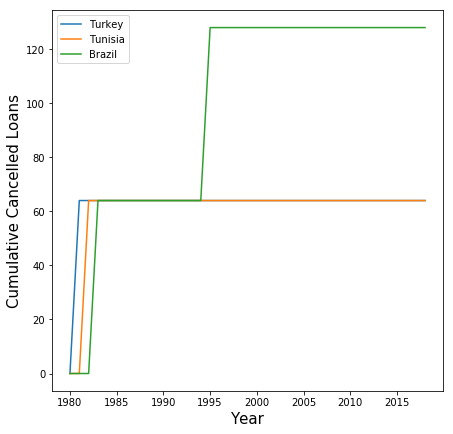

In [49]:
plt.figure(figsize=(7, 7))
plt.xticks(np.arange(0, 39, 5), np.arange(1980, 2019, 5))
plt.xlabel("Year", fontsize=15)
plt.ylabel("Cumulative Cancelled Loans", fontsize=15)

plt.plot(num_cancelled_by_year("Turkey"), label="Turkey")
plt.plot(num_cancelled_by_year("Tunisia"), label="Tunisia")
plt.plot(num_cancelled_by_year("Brazil"), label="Brazil")

plt.legend()

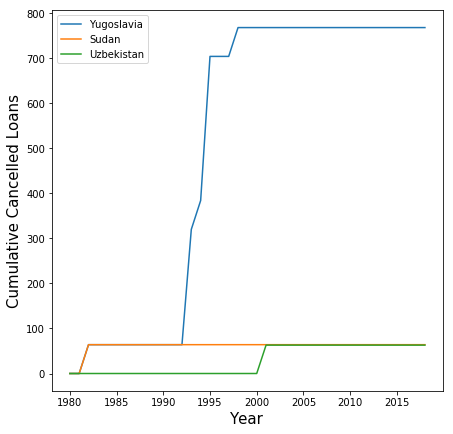

In [50]:
plt.figure(figsize=(7, 7))
plt.xticks(np.arange(0, 39, 5), np.arange(1980, 2019, 5))
plt.xlabel("Year", fontsize=15)
plt.ylabel("Cumulative Cancelled Loans", fontsize=15)

plt.plot(num_cancelled_by_year("Yugoslavia, former"), label="Yugoslavia")
plt.plot(num_cancelled_by_year("Sudan"), label="Sudan")
plt.plot(num_cancelled_by_year("Uzbekistan"), label="Uzbekistan")

plt.legend()

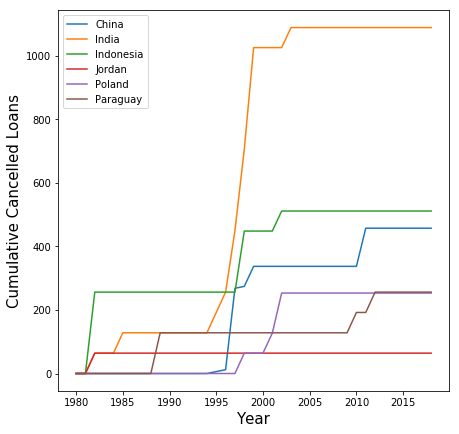

In [51]:
plt.figure(figsize=(7, 7))
plt.xticks(np.arange(0, 39, 5), np.arange(1980, 2019, 5))
plt.xlabel("Year", fontsize=15)
plt.ylabel("Cumulative Cancelled Loans", fontsize=15)

plt.plot(num_cancelled_by_year("China"), label="China")
plt.plot(num_cancelled_by_year("India"), label="India")
plt.plot(num_cancelled_by_year("Indonesia"), label="Indonesia")
plt.plot(num_cancelled_by_year("Jordan"), label="Jordan")
plt.plot(num_cancelled_by_year("Poland"), label="Poland")
plt.plot(num_cancelled_by_year("Paraguay"), label="Paraguay")

plt.legend()

<br/>

### &bull; Observations of Interest

In [52]:
def recession_years(countries):
    keep_idx = []
    for country in countries:
        country_df = ibrd_df[ibrd_df['country']==country][['closed_date_most_recent_']]
        # cancelled loans
        loans = num_cancelled_by_year(country) 
        loans = [loans[0] + x - y for x, y in zip(loans[1:], loans)]
        # recession years
        years = [(loan, year) for loan, year in zip(loans, np.arange(1980, 2019))]
        years = [year[1] for year in years if year[0] != 0]
        print(country, "experienced recessions in", years)
        # indice of loans
        recession = country_df['closed_date_most_recent_'].apply(lambda x : x.year).isin(years)
        idx = country_df[recession].index.tolist()
        keep_idx.append(idx)
    
    keep_idx = [x for y in keep_idx for x in y]
    return keep_idx

def final_dataset(file_name):
    if not os.path.isfile(file_name):
        # filter recession years by country if not processed
        countries = ibrd_df['country'].unique()
        ibrd_df_processed = ibrd_df.loc[recession_years(countries)]
        # write a file
        outfile = open('ibrd_df_processed', 'wb')
        pickle.dump(ibrd_df_processed, outfile)
        outfile.close()
    # load the file in data frame if already processed
    infile = open(file_name, 'rb')
    ibrd_dict = pickle.load(infile)
    ibrd_df = pd.DataFrame.from_records(ibrd_dict)
    infile.close()
    
    return ibrd_df

In [53]:
ibrd_df = final_dataset('ibrd_df_processed')

In [54]:
ibrd_df.shape

(41614, 20)

<br/>

### &bull; Additional Data Cleaning

In [55]:
# date columns
date_cols.pop()
print(date_cols)

# delete date columns
ibrd_df.drop(columns=date_cols, inplace=True)

['agreement_signing_date', 'board_approval_date', 'closed_date_most_recent_', 'effective_date_most_recent_', 'end_of_period', 'first_repayment_date', 'last_repayment_date']


------

<br/>

## Data Clustering: *Borrower, Project*

In [56]:
ibrd_df.drop(columns=['country', 'country_code', 'loan_number', 'project_id'], inplace=True)
ibrd_df['region'] = ibrd_df['region'].astype('category')
display(HTML(ibrd_df.describe(include=['object', 'category'])\
             .drop('count').T.to_html()))

,unique,top,freq
borrower,139,MINISTRY OF FINANCE,8506
loan_type,7,POOL LOAN,17572
project_name_,453,IRRIG. AGRIC. INTENS,390
region,12,EAST ASIA AND PACIFIC,8422


<br/>

### &bull; Borrower

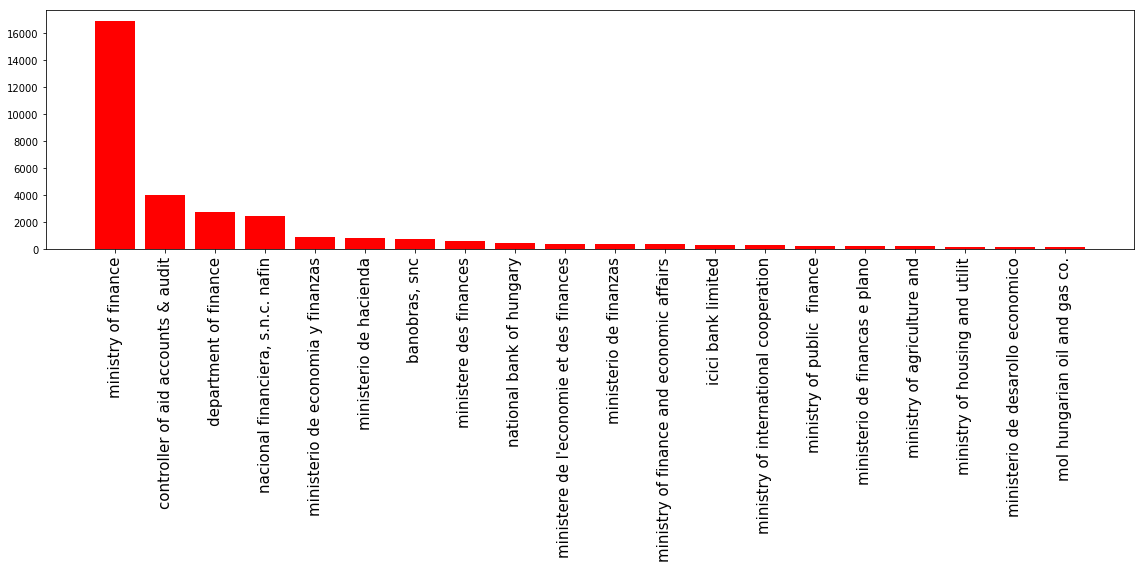

In [57]:
borrowers = [str(x).lower() for x in ibrd_df['borrower']]
common_borrower = Counter(borrowers).most_common()[:20]

plt.figure(figsize=(16, 8))
plt.bar([x[0] for x in common_borrower], [x[1] for x in common_borrower], color='r')
plt.xticks(rotation='vertical', fontsize=15)
plt.tight_layout()
plt.show()

In [58]:
ibrd_df.drop(columns=['borrower'], inplace=True)
print(ibrd_df.shape)

(41614, 8)


<br/>

### &bull; Project Name

In [59]:
def freq_project(proj_names):
    proj_list = []
    roman_num = ['i', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'vii', 'ix', 'x']
    
    for project in list(proj_names):
        words = filter(str.isalpha, project.split(" "))
        for word in words:
            word = word.lower()
            if word not in roman_num:
                proj_list.append(word)
    
    return Counter(proj_list).most_common()

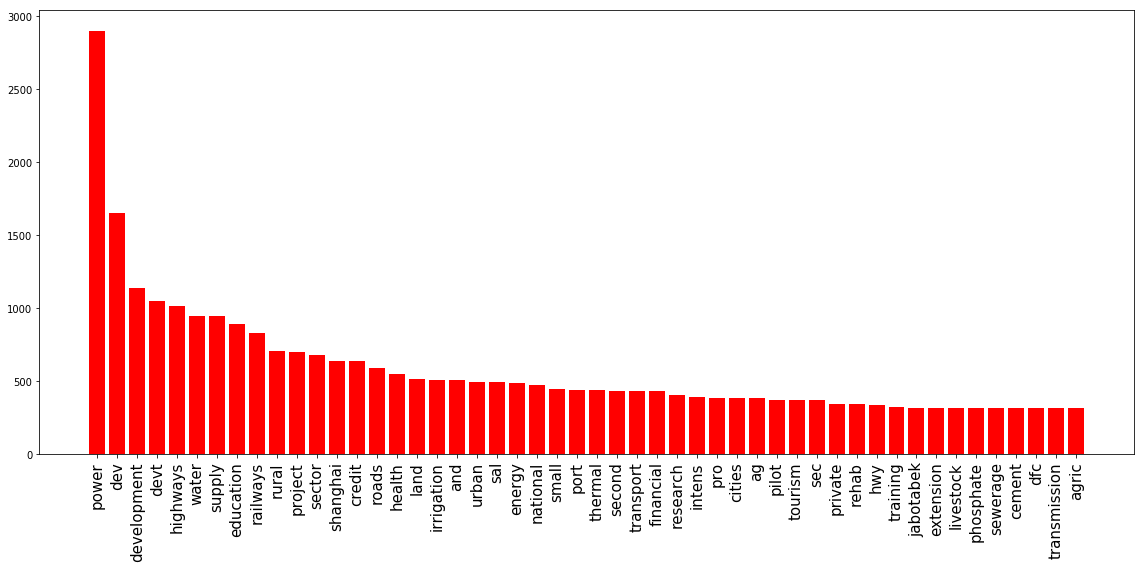

In [60]:
common_proj = freq_project(ibrd_df['project_name_'])[:50]

plt.figure(figsize=(16, 8))
plt.bar([x[0] for x in common_proj], [x[1] for x in common_proj], color='r')
plt.xticks(rotation='vertical', fontsize=15)
plt.tight_layout()
plt.show()

* SAL: Structural Adjustment Loan
* DFC: Dedicated Freight Corridor
* TA: Technical Assistance

In [61]:
proj_dict = {
    'power': ['pw', 'power', 'gas', 'oil', 
              'petroleum', 'energy', 'mining'],
    'education': ['ed', 'edu', 'edc', 'education', 
                  'child', 'children', 'youth'],
    'water': ['wt', 'wtr', 'water'],
    'city': ['city', 'cities', 'urban'],
    'road': ['hwy', 'highway', 'highways', 'rd', 'road', 'roads', 
             'ln', 'lanes', 'rail', 'railway', 'railways'],
    'health': ['hlth', 'health', 'med', 'medical'],
    'transport': ['dfc', 'freight', 'pr', 'port', 'ports', 'transport'],
    'finance': ['credit', 'fin', 'finance', 'investment', 'fund'],
    'rehab': ['rhb', 'rehab', 'rehabilitation'],
    'construction': ['sal', 'rural', 'land', 'reform', 
                     'forestry', 'sewerage', 'housing'],
    'agriculture': ['ag', 'agr', 'agric', 'livestock', 'fertilizer'],
    'industry': ['ind', 'indus', 'industry'],
    'environment': ['env', 'envnt', 'environment'],
    'emergency': ['emer', 'emgy', 'emergency', 'supply']
}

In [62]:
def sector_finder(project_name):
    project_name = project_name.split(" ")
    # handel the convention - country code XX-...
    project_name[0] = re.sub(r"^\w+-", "", project_name[0])
    # each word of at least 2 length
    project_name = list(filter(lambda x : len(x) > 1, project_name))
    
    # look up proj_dict to classify the sector
    sector = ""
    score = 0
    for word in project_name:
        for key, val in proj_dict.items():
            scores = [fuzz.ratio(word.lower(), proj) for proj in val]
            if max(scores) > score:
                sector = key
                score = max(scores)
        # early stop if matched enough
        if score > 95:
            return sector
    # no sector if not enough
    if score < 65:
        return "other"
    
    return sector

In [63]:
ibrd_df['project_sector'] = ibrd_df['project_name_'].apply(lambda x : sector_finder(x))
ibrd_df.drop('project_name_', axis=1, inplace=True)
print(ibrd_df.shape)

(41614, 8)


In [64]:
ibrd_df['region'] = ibrd_df['region'].apply(lambda x: x.upper()).astype('category')
ibrd_df['project_sector'] = ibrd_df['project_sector'].astype('category')
display(HTML(ibrd_df.describe(include=['category']).drop('count').T.to_html()))

,unique,top,freq
loan_type,7,POOL LOAN,17572
region,6,EAST ASIA AND PACIFIC,16752
project_sector,15,other,13717


------

<br/>

## Feature Selection

In [65]:
"""
Draw the distributions of repaid and cancelled loans together
Add the means as vertical lines
"""
def feature_dist(col, xlabel, repaid, cancelled):
    repaid_mean = np.mean(repaid)
    cancelled_mean = np.mean(cancelled)
    # plot distributions
    plt.figure(figsize=(8,6))
    sns.kdeplot(repaid, shade=True, label="Repaid")
    sns.kdeplot(cancelled, shade=True, label="Cancelled")
    # decoration
    plt.axvline(x=repaid_mean, linestyle='--', linewidth=0.75)
    plt.axvline(x=cancelled_mean, linestyle='--', linewidth=0.75, color='coral')
    plt.title("Distribution of "+ '"' + col + '"', fontsize=15)
    plt.xlabel(xlabel, fontsize=12)
    plt.show()

    
"""
Conduct Mann-Whitney test on two distributions
Scale the data between (-1,+1): x_scaled = 2*(x - min(x_origin))/range(x_origin) - 1
"""
def mann_whitney(col, xlabel):
    repaid = ibrd_df[ibrd_df['loan_status']==0][col]
    cancelled = ibrd_df[ibrd_df['loan_status']==1][col]
    # plot and print
    print("Repaid - mean:", np.mean(repaid), "/ median:", np.median(repaid))
    print("Cancelled - mean:", np.mean(cancelled), "/ median:", np.median(cancelled))
    feature_dist(col, xlabel, repaid, cancelled)
    
    # Mann-Whitney test
    p_value = sc.stats.mannwhitneyu(repaid, cancelled).pvalue
    
    print("P-value:", p_value)
    if p_value < 0.05:
        print("Distributions of", col, "by loan repaid or cancelled are different at alpha=0.05")
    else:
        print("Distributions of", col, "by loan repaid or cancelled are not different at alpha=0.05")

<br/>

### &bull; Numerical Data: *Statistical Analysis*

Repaid - mean: 6.169062338848055 / median: 6.9
Cancelled - mean: 5.548070966081736 / median: 6.93


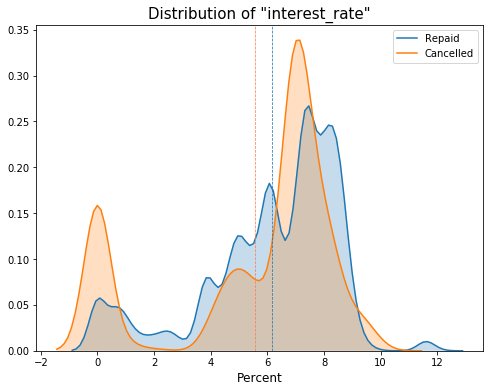

P-value: 1.708467482901202e-67
Distributions of interest_rate by loan repaid or cancelled are different at alpha=0.05


In [66]:
mann_whitney('interest_rate', "Percent")

In [67]:
repaid = ibrd_df[ibrd_df['loan_status']==0]['interest_rate']
cancelled = ibrd_df[ibrd_df['loan_status']==1]['interest_rate']

repaid = repaid[repaid!=0]
cancelled = cancelled[cancelled!=0]

print("Mean (without 0%) - Repaid:", np.mean(repaid), "/ Cancelled:", np.mean(cancelled))
print("Median (without 0%) - Repaid:", np.median(repaid), "/ Cancelled:", np.median(cancelled))

Mean (without 0%) - Repaid: 6.419447594063373 / Cancelled: 6.85001828612225
Median (without 0%) - Repaid: 7.0 / Cancelled: 7.07


Repaid - mean: 59232298.53392448 / median: 25000000.0
Cancelled - mean: 42755877.14606002 / median: 20000000.0


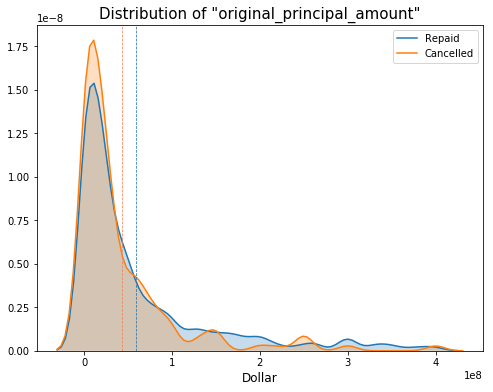

P-value: 4.2478122911741e-61
Distributions of original_principal_amount by loan repaid or cancelled are different at alpha=0.05


In [68]:
mann_whitney('original_principal_amount', "Dollar")

Repaid - mean: 126.25136362251273 / median: 36.0
Cancelled - mean: 109.08457428668865 / median: 45.0


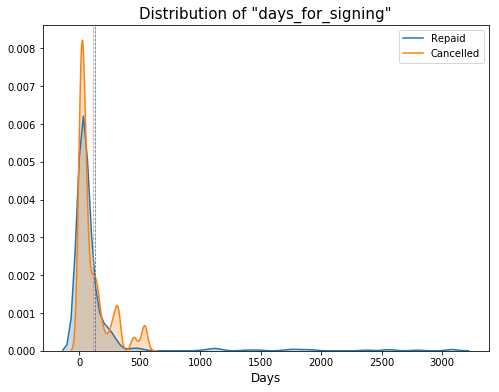

P-value: 4.388425396846735e-62
Distributions of days_for_signing by loan repaid or cancelled are different at alpha=0.05


In [69]:
mann_whitney('days_for_signing', "Days")

Repaid - mean: 4851.941006185818 / median: 5294.0
Cancelled - mean: 4369.113106740934 / median: 4564.0


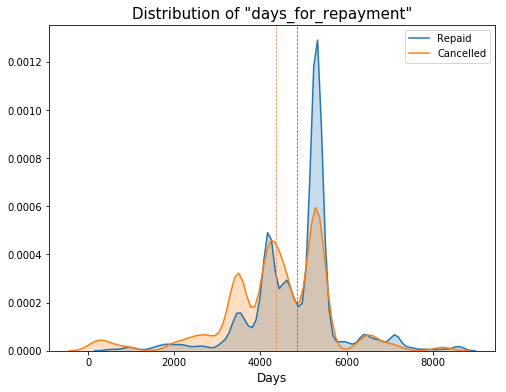

P-value: 0.0
Distributions of days_for_repayment by loan repaid or cancelled are different at alpha=0.05


In [70]:
mann_whitney('days_for_repayment', "Days")

<br/>

### &bull; Categorical Data

In [71]:
def feature_bar(col):
    cancel_sum = ibrd_df.groupby([col])['loan_status'].sum()
    loan_total = ibrd_df.groupby([col])['loan_status'].count()
    # loan_total = loan_total[loan_total!=0]
    cate_df = pd.concat([cancel_sum, loan_total], axis=1)
    cate_df.columns = ['cancel_sum', 'loan_total']
    print("Cancellation Rate by", col)
    print(cate_df.cancel_sum/cate_df.loan_total)
    # cate_df.dropna(axis=0, inplace=True)
    tidy_df = (
        cate_df.stack().reset_index().
        rename(columns={'level_1': 'variable', 0: 'value'})
    )
    
    plt.figure(figsize=(12,6))
    sns.barplot(x=col, y='value', hue='variable', data=tidy_df)
    sns.despine()
    plt.title("Loan Count by " + '"' + col + '"', fontsize=15)
    plt.xticks(rotation=70)
    plt.xlabel("")
    plt.ylabel("Count", fontsize=12)
    plt.show()

Cancellation Rate by loan_type
loan_type
BLOAN         1.000000
FSL           1.000000
NON POOL      0.159745
POOL LOAN     0.210847
SCP EUR       0.000000
SCP JPY            NaN
SCP USD       0.000000
SNGL CRNCY    0.344801
dtype: float64


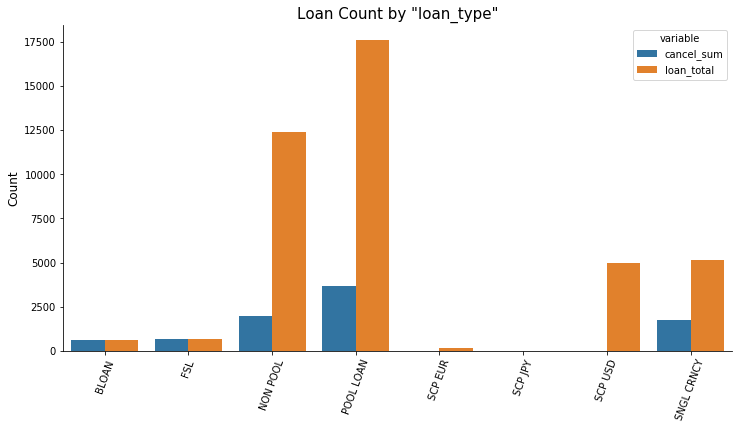

In [72]:
feature_bar('loan_type')

Cancellation Rate by region
region
AFRICA                          0.500560
EAST ASIA AND PACIFIC           0.084527
EUROPE AND CENTRAL ASIA         0.395829
LATIN AMERICA AND CARIBBEAN     0.264013
MIDDLE EAST AND NORTH AFRICA    0.322196
SOUTH ASIA                      0.214485
dtype: float64


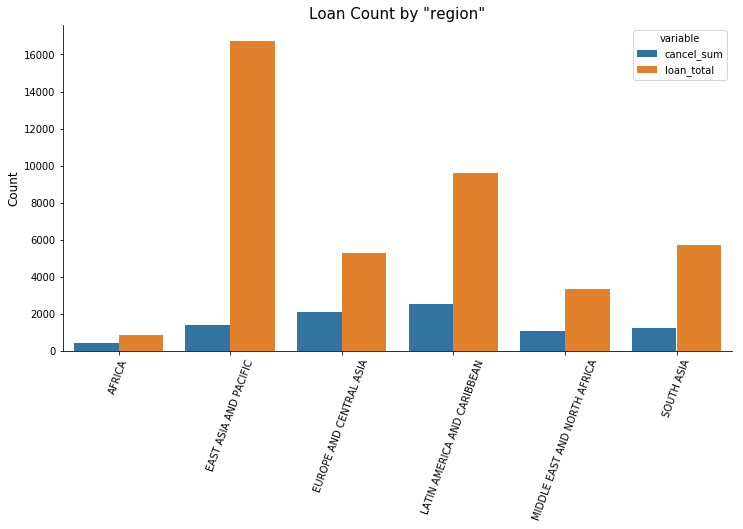

In [73]:
feature_bar('region')

Cancellation Rate by project_sector
project_sector
agriculture     0.373171
city            0.084433
construction    0.312549
education       0.336627
emergency       0.479899
environment     0.087866
finance         0.497995
health          0.064322
industry        0.286140
other           0.166582
power           0.143416
rehab           0.585253
road            0.224285
transport       0.086380
water           0.329453
dtype: float64


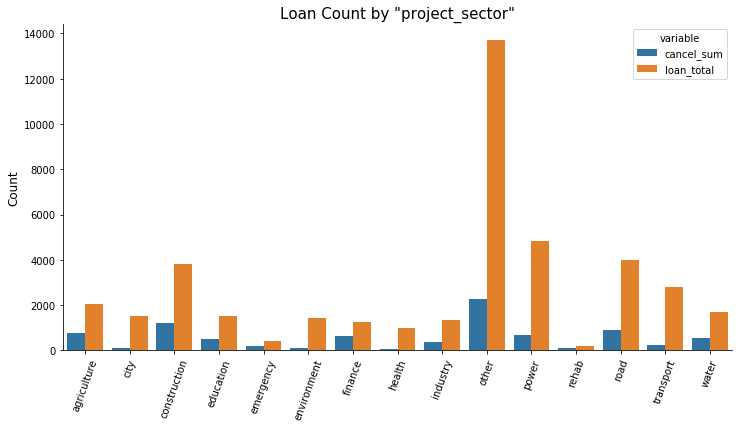

In [74]:
feature_bar('project_sector')

<br/>

### &bull; Considering Both: *Boxplot, Scatterplot*

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

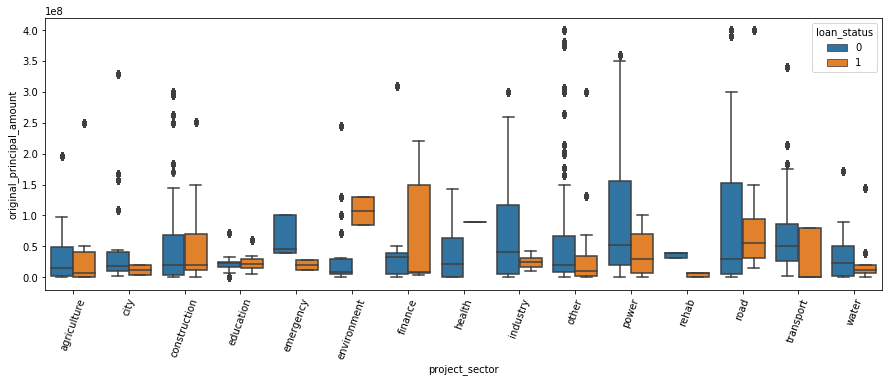

In [75]:
plt.figure(figsize=(15,5))
sns.boxplot(x='project_sector', y='original_principal_amount', 
            hue='loan_status', data=ibrd_df)
plt.xticks(rotation=70)

------

<br/>

## Modeling and Evaluation

In [76]:
ibrd_target_name = ['loan_status']
ibrd_feature_names = list(set(ibrd_df.columns)-set(ibrd_target_name))
print("Final ibrd_df columns")
pprint(list(ibrd_df.columns))

Final ibrd_df columns
['interest_rate',
 'loan_status',
 'loan_type',
 'original_principal_amount',
 'region',
 'days_for_signing',
 'days_for_repayment',
 'project_sector']


In [77]:
def balance_dataset(df, size):
    repaid_df = df[df['loan_status']==0]
    cancelled_df = df[df['loan_status']==1]

    repaid_idx = np.random.choice(list(repaid_df.index), 
                                  int(len(cancelled_df)*size), replace=False)
    repaid_balanced_df = df.loc[repaid_idx]

    cancelled_idx = np.random.choice(list(cancelled_df.index), 
                                     int(len(cancelled_df)*size), replace=False)
    cancelled_balanced_df = ibrd_df.loc[cancelled_idx]

    balanced_df = pd.concat([repaid_balanced_df, cancelled_balanced_df])
    balanced_df = shuffle(balanced_df)
    
    return balanced_df

def split_X_y(df, features):
    cate_cols = df.select_dtypes(include='category').columns
    for col in cate_cols:
        le = ppr.LabelEncoder()
        le.fit(df[col])
        df[col] = le.transform(df[col])
    
    X = np.array(df[features])
    y = np.array(df['loan_status'])
    
    return X, y

In [78]:
# balanced training set
train_df = balance_dataset(ibrd_df, 0.8)
print("Size of balanced training dataset:", len(train_df))
print("Count of cancelled loans in balanced training dataset:", 
      len(train_df[train_df['loan_status']==1]))

# training set X, y
train_X, train_y = split_X_y(train_df, ibrd_feature_names)

Size of balanced training dataset: 14074
Count of cancelled loans in balanced training dataset: 7037


In [79]:
# balanced validation set
valid_df = ibrd_df.iloc[list(set(ibrd_df.index)-set(train_df.index))]
valid_df = balance_dataset(valid_df, 1)
print("Size of balanced validation dataset:", len(valid_df))
print("Count of cancelled loans in balanced validation dataset:", 
      len(valid_df[valid_df['loan_status']==1]))

# validation set X, y
valid_X, valid_y = split_X_y(valid_df, ibrd_feature_names)

Size of balanced validation dataset: 3520
Count of cancelled loans in balanced validation dataset: 1760


<br/>

### &bull; Base Model

In [80]:
def model_evaluation(clf, train_X, train_y, valid_X, valid_y):
    scores = cross_val_score(clf, train_X, train_y, cv=5)
    clf.fit(train_X, train_y)
    pred = clf.predict(valid_X)
    
    # 95% confidence interval (=about 2 std width)
    print("Cross Validation Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()*2))
    # confusion matrix, precision, recall, f-score
    print("\nPrediction against Validation Set\n- Confusion Matrix\n", confusion_matrix(valid_y, pred))
    print("\n- Classification Report\n", classification_report(valid_y, pred))
    print("\t(0: Repaid, 1: Cancelled)")

In [81]:
model_evaluation(GaussianNB(), train_X, train_y, valid_X, valid_y)

Cross Validation Accuracy: 0.54 (+/- 0.01)

Prediction against Validation Set
- Confusion Matrix
 [[ 338 1422]
 [ 217 1543]]

- Classification Report
              precision    recall  f1-score   support

          0       0.61      0.19      0.29      1760
          1       0.52      0.88      0.65      1760

avg / total       0.56      0.53      0.47      3520

	(0: Repaid, 1: Cancelled)


<br/>

### &bull; Prediction Models

In [82]:
model_evaluation(tree.DecisionTreeClassifier(), 
                 train_X, train_y, valid_X, valid_y)

Cross Validation Accuracy: 1.00 (+/- 0.00)

Prediction against Validation Set
- Confusion Matrix
 [[1757    3]
 [   0 1760]]

- Classification Report
              precision    recall  f1-score   support

          0       1.00      1.00      1.00      1760
          1       1.00      1.00      1.00      1760

avg / total       1.00      1.00      1.00      3520

	(0: Repaid, 1: Cancelled)


In [83]:
model_evaluation(SVC(), train_X, train_y, valid_X, valid_y)

Cross Validation Accuracy: 1.00 (+/- 0.00)

Prediction against Validation Set
- Confusion Matrix
 [[1760    0]
 [   0 1760]]

- Classification Report
              precision    recall  f1-score   support

          0       1.00      1.00      1.00      1760
          1       1.00      1.00      1.00      1760

avg / total       1.00      1.00      1.00      3520

	(0: Repaid, 1: Cancelled)


In [84]:
model_evaluation(GradientBoostingClassifier(), 
                 train_X, train_y, valid_X, valid_y)

Cross Validation Accuracy: 0.96 (+/- 0.02)

Prediction against Validation Set
- Confusion Matrix
 [[1643  117]
 [  46 1714]]

- Classification Report
              precision    recall  f1-score   support

          0       0.97      0.93      0.95      1760
          1       0.94      0.97      0.95      1760

avg / total       0.95      0.95      0.95      3520

	(0: Repaid, 1: Cancelled)


<br/>

### &bull; Model Selection: *Decision Tree*

In [85]:
# training
dtree = tree.DecisionTreeClassifier()
dtree.fit(train_X, train_y)
# graphical data
dot_data = tree.export_graphviz(dtree, out_file=None, 
                                feature_names=ibrd_feature_names,  
                                class_names=['Reapid', 'Cancelled'],
                                filled=True, rounded=True,  
                                special_characters=True)  
# generate a graph
graph = graphviz.Source(dot_data)
graph.render('ibrd_tree')

IFrame('ibrd_tree.pdf', width=800, height=400)

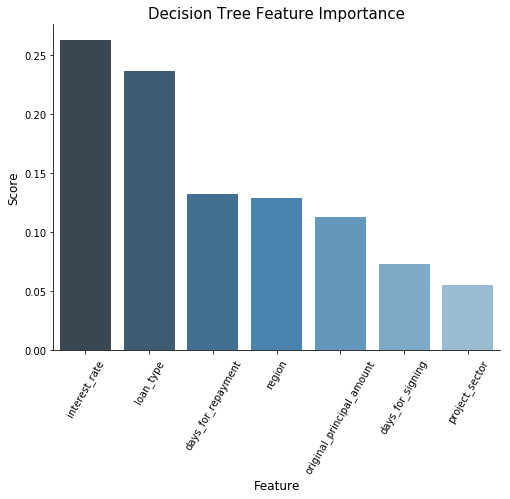

In [86]:
feature_scores = list(dtree.feature_importances_)
dtree_feature = pd.DataFrame({'feature': ibrd_feature_names, 
                              'score': feature_scores})
dtree_feature.sort_values(by='score', ascending=False, inplace=True)

plt.figure(figsize=(8,6))
sns.barplot(x='feature', y='score', data=dtree_feature, 
            palette='Blues_d')
sns.despine()
plt.title("Decision Tree Feature Importance", fontsize=15)
plt.xlabel("Feature", fontsize=12)
plt.xticks(rotation=60)
plt.ylabel("Score", fontsize=12)

plt.show()

In [87]:
train_less_X, train_less_y = split_X_y(train_df, ['loan_type', 'interest_rate'])
valid_less_X, valid_less_y = split_X_y(valid_df, ['loan_type', 'interest_rate'])

model_evaluation(tree.DecisionTreeClassifier(),
                 train_less_X, train_less_y, valid_less_X, valid_less_y)

Cross Validation Accuracy: 0.89 (+/- 0.01)

Prediction against Validation Set
- Confusion Matrix
 [[1555  205]
 [ 226 1534]]

- Classification Report
              precision    recall  f1-score   support

          0       0.87      0.88      0.88      1760
          1       0.88      0.87      0.88      1760

avg / total       0.88      0.88      0.88      3520

	(0: Repaid, 1: Cancelled)


------

<br/>

## Conclusion

------

<br/>

## Reference

* [The World Bank Source](https://datacatalog.worldbank.org/dataset/ibrd-statement-loans-historical-data)
* [Socrata Meta Data](https://dev.socrata.com/foundry/finances.worldbank.org/x433-52wt)
* [Sodapy](https://pypi.org/project/sodapy/)
* [Plotly Map](https://plot.ly/python/choropleth-maps/)
* [SAL project](http://projects.worldbank.org/P004484/structural-adjustment-loan-sal-project-01?lang=en)
* [DFC project](http://www.projects.worldbank.org/P150158?lang=en)
* [plotly ttest](https://plot.ly/python/t-test/)
* [Mann-whitney](https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/)